# pytorch workflow

In [ ]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build a model",
                      3: "fitting the model to the data (training)",
                      4: "making predictions and evaluating a model (inference)",
                      5: "save and load a model",
                      6: " put it all together"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build a model',
 3: 'fitting the model to the data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'save and load a model',
 6: ' put it all together'}

In [ ]:
import torch
from torch import nn # nn contains all of pytorch's building blocks for neural networks
import matplotlib.pyplot as plt

# check the pytorch version
torch.__version__

'2.1.0+cu121'

## 1. Data (Preparing and loading)

Data can be almost anything... in machine learning

* excel spreadsheet
* images of any kind
* videos
* audio like songs and podcast
* DNA
* text

Machine learning is a game of two parts:
1. get data into a numerical representation.
2. build a model to learn patterns in that numerical representation.

To showcase this,  lets create some *known* data using the linear regression formula.

We'll use a linear regression fomula to make a straight line with *known* **parameters**.

How do you calculate linear regression? The Linear Regression Equation : The equation has the form Y= a + bX, where Y is the dependent variable (that's the variable that goes on the Y-axis), X is the independent variable (i.e. it is plotted on the X-axis), b is the slope of the line, and a is the y-intercept.

In [ ]:
# Create *known* parameters
weight = 0.7 # - b
bias = 0.3 # - a

# create
start =  0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len(y)

(50, 50)

### splitting data into train and test sets

In [ ]:
# Create train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training Data')

  # plot testing data in green
  plt.scatter(test_data, test_labels, c='orange', s=4, label='Testing Data')

  # Are there predictions?
  if predictions is not None:
    # plot the predictions if they exist
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  # show the legend
  plt.legend(prop={"size": 14});

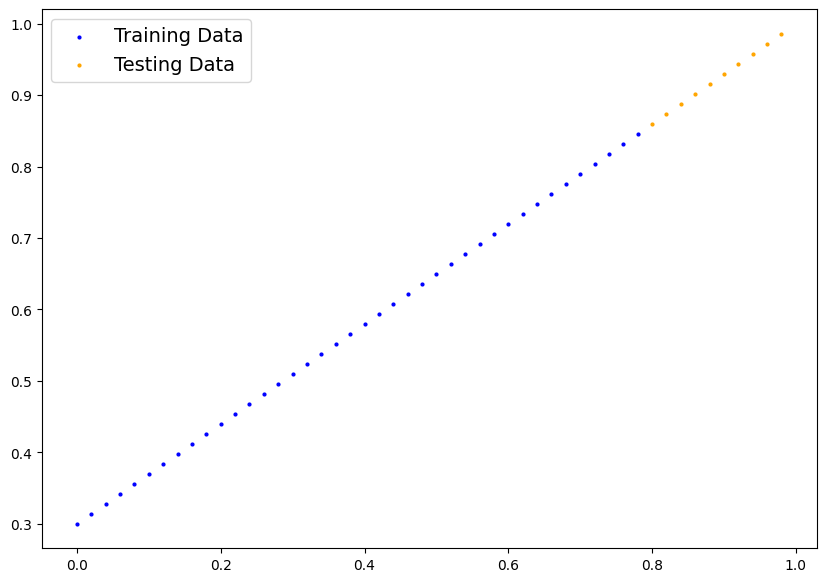

In [ ]:
plot_predictions()

## Build a model

What our model does:
* start with random values (weight an bias)
* look at training data and adjust the random values to better represent the ideal values (the weight and bais values we used to create the data)

How does it do so?

Through two main algorithms:
1. gradient descent
2. backpropagation

In [ ]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # almost everything in pytorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype= torch.float))

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # foward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- 'x' is the input data
    return self.weights * x + self.bias # this is the linear regression formula

### pytorch model building essentials

* torch.nn - contains all of the building blocks for computational graphs
(such as a neural networks)
* torch.nn.Parameter - what paramters should our model try to learn, often a pytorch layer from torch.nn will set these for us.
* torch.nn.Module - The base class for all neural network modules, if you subclass it you should overwrite forward()
* torch.optim - this is where the optimizers in pytorch live, they will help with gradient descent.
* def foward() - all nn.module subclasses require you to overwrite foward(), this method defines what happens in the foward computation


### checking the contents of our pytorch model

we can check our model paramters or whats inside our model by using `.parameters()`

In [ ]:
# create a random seed
torch.manual_seed(42)

# create an instance of the model (this is a subclass of nn.module)
model_0 = LinearRegressionModel()

# check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
weight, bias # the model is going to evaluate the data to get as close as possible to the correct weights and biases

(0.7, 0.3)

### Making predictions using `torch.inference_mode()`

To check our model's predictive power, lets see how well it predicts `y_test` based on `X_test`.

when we pass data through our model, its going to run it through the foward method

In [ ]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [ ]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

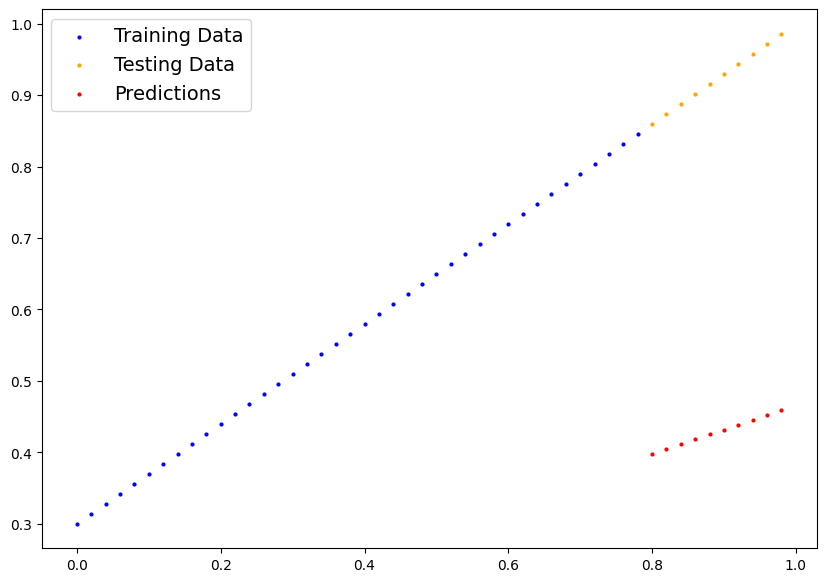

In [ ]:
plot_predictions(predictions=y_preds)

# 3. Train model

the idea of training a model is to go from unknown parameters to some known parameters.
from a poor representation to a good representation of the data.

One way to measure how poor or how wrong the models predictions are is to use a loss function.

* Note: loss function may also be called the cost function or criterion in different areas.

Things we need to train:

* **Loss function:** a function to measure how wrong your predictions are to the ideal output, so lower is better

* **Optimizer:** takes into account the loss of a model and adjust the models parameters (e.g. weights and bias) to improve the loss function.
 * inside an optimizer youll often have to set two parameters:
   * **params :**  the model parameters youd like to optimize, for example params=model_0.parameters()
   * **lr (learning rate) :** the learning rate is a hyperparamter that defines how big/small the optimizer changes the parameters with each step(a small lr results in small changes, a large lr results in large changes)

And specifically for pytorch, we need:
* A training loop
* A testing loop

In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stocastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate

In [ ]:
loss_fn

L1Loss()

### Building a training loop (and a testing loop) in Pytorch

the things we need in a training loop:
* 1. loop through the data
* 2. forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data- also called forward propagation
* 3. calculate the loss (compare forward pass predictions to ground truth labels)
* 4. optimizer zero grad
* 5. loss backward - move backwards through the network to calculate the gradients of each of parameters of our model with respect to the loss (**backpropagation**)
* 6. optimizer step - use the optimizer to adjust our models parameters to try and improve the loss (**gradient descent**)


In [ ]:
torch.manual_seed(42)

# an epoch is one loop through the data..(this is a hyperparameter since we are setting it ourselves)
epochs = 200

# Tracking Different Values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 1. loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # train mode in pytorch sets all parameters that require gradients to require gradients

  # 2. Forward pass
  y_pred = model_0(X_train)

  # 3. calculate the loss
  loss = loss_fn(y_pred, y_train)
  # print(f"loss: {loss}")

  # 4. optimizer zero grad
  optimizer.zero_grad()

  # 5. perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 6. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate
                   # through the loop so we have to zero them in step 4 for the next iteration of the loop


  ### Testing
  model_0.eval() # turns off settings not needed for evaluations/testing
  with torch.inference_mode(): # turns off gradient tracking
    # 1. do the forward pass
    test_pred = model_0(X_test)

    # 2. calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # print out whats happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"epoch: {epoch} | loss: {loss} | test loss: {test_loss}")
  # print out model state_dict()
    print(model_0.state_dict())


epoch: 0 | loss: 0.31288138031959534 | test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
epoch: 10 | loss: 0.1976713240146637 | test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
epoch: 20 | loss: 0.08908725529909134 | test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
epoch: 30 | loss: 0.053148526698350906 | test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
epoch: 40 | loss: 0.04543796554207802 | test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
epoch: 50 | loss: 0.04167863354086876 | test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
epoch: 60 | loss: 0.03818932920694351 | test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [ ]:
import numpy as np

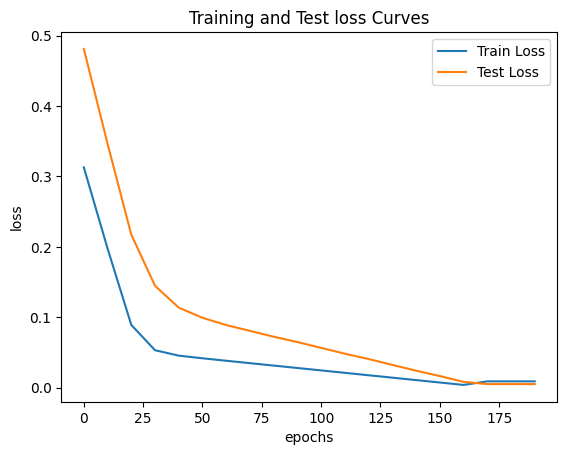

In [ ]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values)), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and Test loss Curves")
plt.ylabel("loss")
plt.xlabel('epochs')
plt.legend()

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
weight, bias

(0.7, 0.3)

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

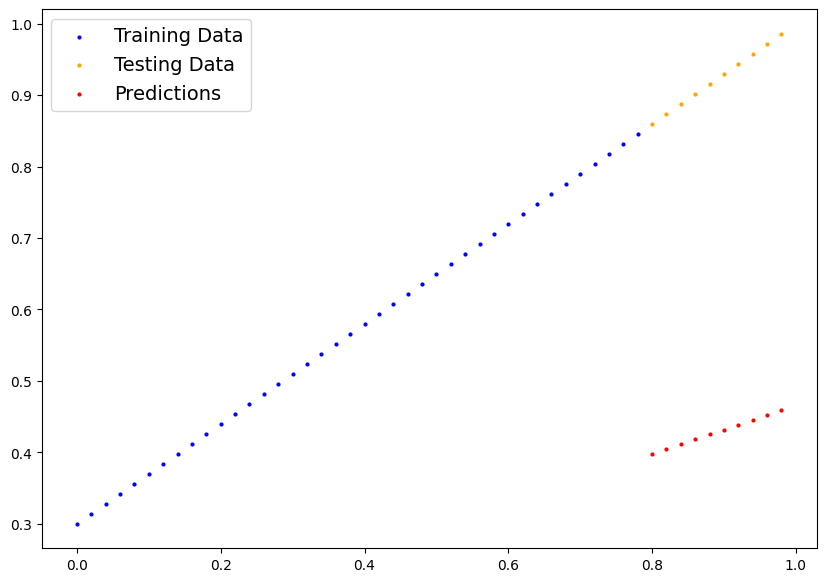

In [ ]:
plot_predictions(predictions=y_preds);

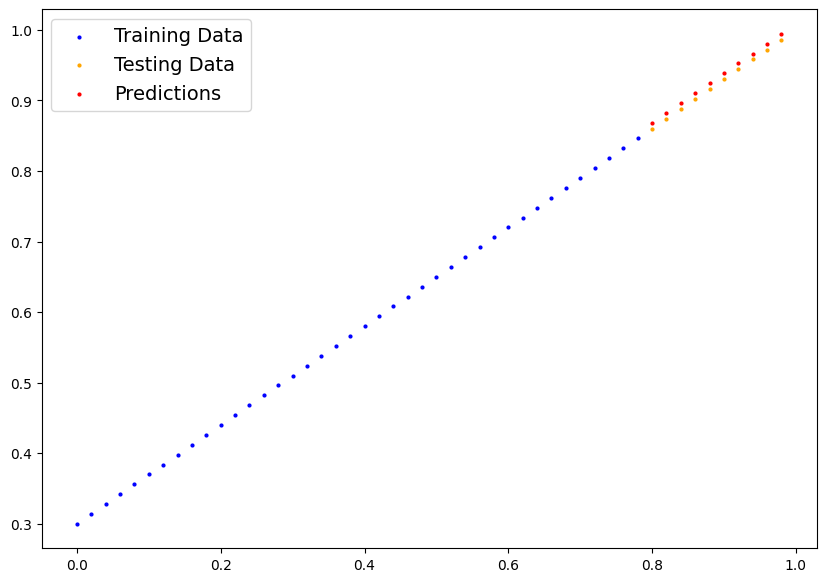

In [ ]:
plot_predictions(predictions=y_preds_new)

### Saving a model in pytorch

There are three main methods you should know about for saving and loading models in pytorch.

1. `torch.save() `- allows you to save a pytorch object in pythons pickle format
2. `torch.load()`- allows you to load a saved pytorch object
3. `torch.nn.Module.load_state_dict()` - this allows you to load a models saved state dictionary

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Saving a model
from pathlib import Path

# 1. create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f" Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

 Saving model to : models/01_pytorch_workflow_model_0.pth


## Loading a pytorch model

Since we saved our models "state_dict() rather than the entire model,  well create a new instancte of our model class and load the saved state_dict() into that

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])

In [ ]:
# make some model preds
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

### Putting it all together
lets go back through the steps above and see it all in one place

In [ ]:
# create device agnostic code.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

using device: cuda


In [ ]:
# create some data using linear regression formula y = weight * X + bias
weight = 0.7
bias = 0.3

# create range values
start = 0
end = 1
step = 0.02

# Create x and y (features and labels)
x = torch.arange(start,  end,  step).unsqueeze(dim=1) # without unsqueeze errors with pop up
y = weight * x + bias
x[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# split data
train_split = int(0.8 * len(x))
x_train, y_train = x[:train_split], y[:train_split]
x_test, y_test = x[train_split:], y[train_split:]

len(x_train), len(y_train), len(x_test), len(y_test)

(40, 40, 10, 10)

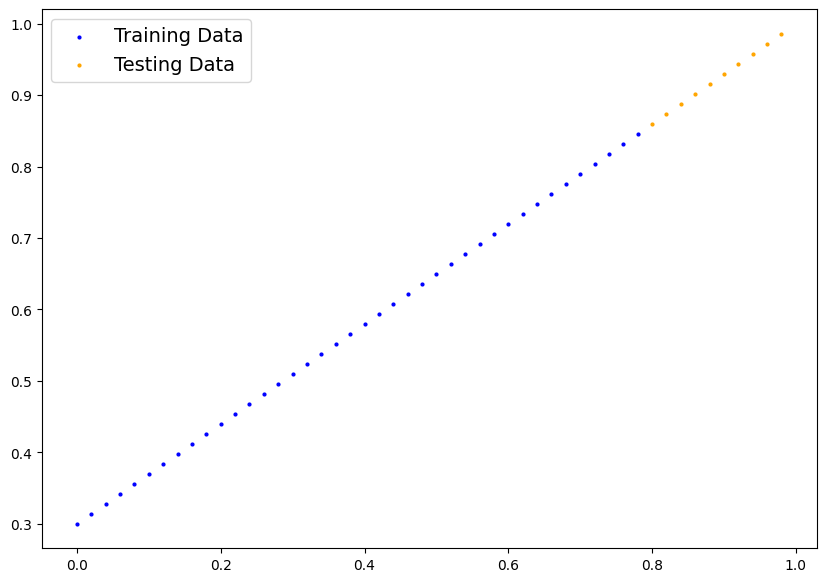

In [ ]:
# plot the data
plot_predictions(x_train, y_train, x_test, y_test)

### building a linear model create a linear model by subclassing nn.module

In [ ]:
### building a linear model
# create a linear model by subclassing nn.module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1, # so take in one feature 'x' and output one feature 'y'
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1,  model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# check the models current device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### Training

For training we need:
* loss function
* optimizer
* training loop
* testing loop


In [ ]:
# set up the loss function
loss_fn = nn.L1Loss() # same as MAE

# set up the optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # these are the parameters we want our model to optimize
                            lr=0.01)

In [ ]:
# lets write a training loop
torch.manual_seed(42)

epochs = 200

# device agnostic code for data (put data on the target device)
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. forward pass
  y_pred = model_1(x_train)

  # calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. perform backpropagation
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(x_test)

    test_loss = loss_fn(test_pred, y_test)

  # print out whats happening
  if epoch % 10 == 0:
    print(f"epoch: {epoch} | Loss: {loss} | test_loss: {test_loss}")

epoch: 0 | Loss: 0.5551779866218567 | test_loss: 0.5739762187004089
epoch: 10 | Loss: 0.439968079328537 | test_loss: 0.4392664134502411
epoch: 20 | Loss: 0.3247582018375397 | test_loss: 0.30455657839775085
epoch: 30 | Loss: 0.20954833924770355 | test_loss: 0.16984669864177704
epoch: 40 | Loss: 0.09433845430612564 | test_loss: 0.03513690456748009
epoch: 50 | Loss: 0.023886388167738914 | test_loss: 0.04784907028079033
epoch: 60 | Loss: 0.019956795498728752 | test_loss: 0.045803118497133255
epoch: 70 | Loss: 0.016517987474799156 | test_loss: 0.037530567497015
epoch: 80 | Loss: 0.013089174404740334 | test_loss: 0.02994490973651409
epoch: 90 | Loss: 0.009653178043663502 | test_loss: 0.02167237363755703
epoch: 100 | Loss: 0.006215683650225401 | test_loss: 0.014086711220443249
epoch: 110 | Loss: 0.00278724217787385 | test_loss: 0.005814164876937866
epoch: 120 | Loss: 0.0012645035749301314 | test_loss: 0.013801801018416882
epoch: 130 | Loss: 0.0012645035749301314 | test_loss: 0.013801801018416

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### Making and evaluating predictions

In [ ]:
# turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(x_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

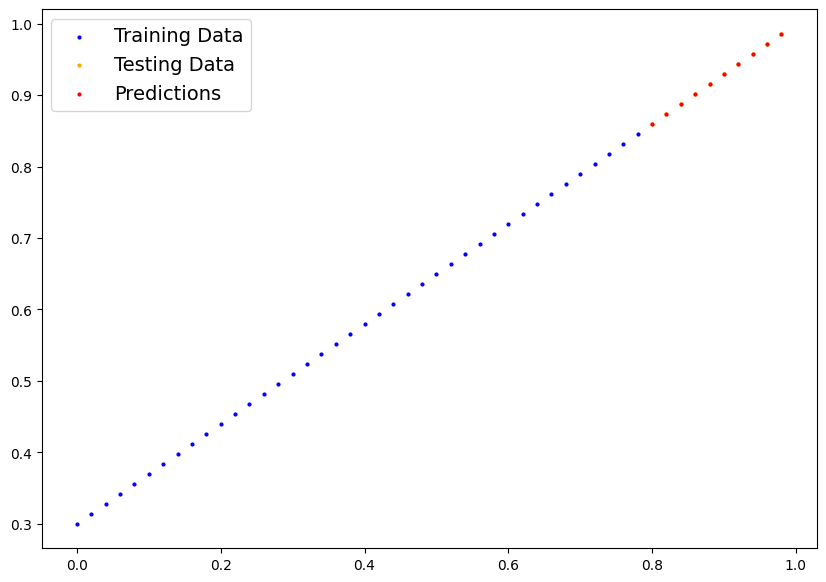

In [ ]:
plot_predictions(predictions=y_preds.cpu())

### saving and loading a trained model

In [ ]:
from pathlib import Path

# create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create a model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save the model state dict
print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
# load a pytorch model

# create a new instance of linear regression model v2
loaded_model_1 = LinearRegressionModelV2()

# Load and saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [ ]:
# evaluate the loaded model
loaded_model_1.eval()
with torch.inference_mode():
  X_test = X_test.to(device)
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

In [ ]:
y_preds.device

device(type='cuda', index=0)

### exercises and extra curriculum

In [ ]:
# data parameters
weight = 0.3
bias = 0.9

# create
start = 0
end = 1
step = 0.01

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

len(X), len(y)


(100, 100)

In [ ]:
# splitting the data into training and test splits
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

In [ ]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training Data')

  # plot testing data in green
  plt.scatter(test_data, test_labels, c='orange', s=4, label='Testing Data')

  # Are there predictions?
  if predictions is not None:
    # plot the predictions if they exist
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  # show the legend
  plt.legend(prop={"size": 14});

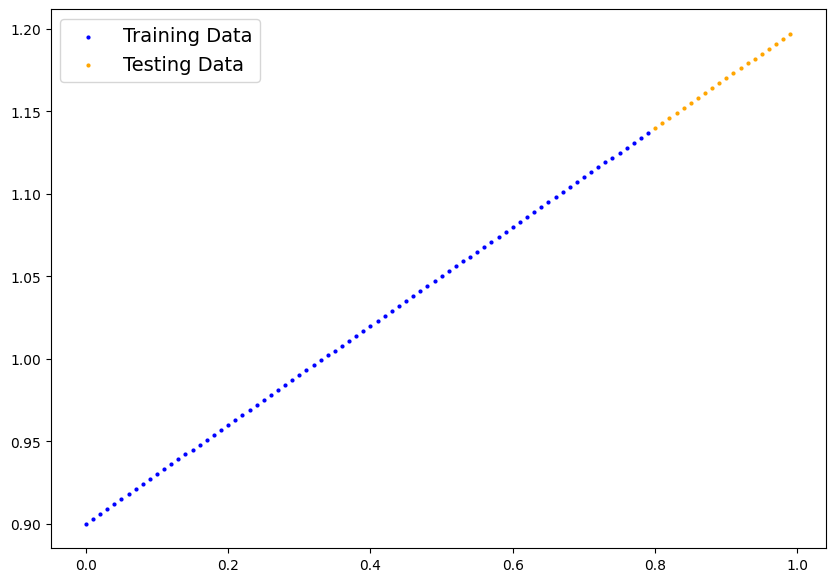

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test)

### building model practice

In [ ]:
class LinearRegressionModelV3(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)


In [ ]:
# setting the manual seed
torch.manual_seed(42)
model_2 = LinearRegressionModelV3()
model_2, model_2.state_dict()

(LinearRegressionModelV3(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
next(model_2.parameters()).device

device(type='cpu')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model_2.to(device)
next(model_2.parameters()).device

device(type='cuda', index=0)

### model training practice
For training we need:
* loss function
* optimizer
* training loop
* testing loop

In [ ]:
torch.manual_seed(42)

# set up the loss function
loss_fn = nn.L1Loss()

# set up the optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

# lets a write training loop
epochs = 400

# device agnostic code
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# loop
for epoch in range(epochs):
  model_2.train()

  # 1. forward pass
  y_pred = model_2(X_train)

  # 2. loss function
  loss = loss_fn(y_pred, y_train)

  # 3. zero gradient
  optimizer.zero_grad()

  # 4. backpropagation
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  ### Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test)
    test_loss = loss_fn(test_pred, y_test)

  # print whats happening
  if epoch % 20 == 0:
    print(f"epoch: {epoch} | loss {loss} | test loss {test_loss}")



epoch: 0 | loss 0.007878492586314678 | test loss 0.007064235396683216
epoch: 20 | loss 0.007878492586314678 | test loss 0.007064235396683216
epoch: 40 | loss 0.007878492586314678 | test loss 0.007064235396683216
epoch: 60 | loss 0.007878492586314678 | test loss 0.007064235396683216
epoch: 80 | loss 0.007878492586314678 | test loss 0.007064235396683216
epoch: 100 | loss 0.007878492586314678 | test loss 0.007064235396683216
epoch: 120 | loss 0.007878492586314678 | test loss 0.007064235396683216
epoch: 140 | loss 0.007878492586314678 | test loss 0.007064235396683216
epoch: 160 | loss 0.007878492586314678 | test loss 0.007064235396683216
epoch: 180 | loss 0.007878492586314678 | test loss 0.007064235396683216
epoch: 200 | loss 0.007878492586314678 | test loss 0.007064235396683216
epoch: 220 | loss 0.007878492586314678 | test loss 0.007064235396683216
epoch: 240 | loss 0.007878492586314678 | test loss 0.007064235396683216
epoch: 260 | loss 0.007878492586314678 | test loss 0.00706423539668321

### evaluating the model practice

In [ ]:
# evaluating the model
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test)

y_preds

tensor([[1.1333],
        [1.1363],
        [1.1393],
        [1.1423],
        [1.1454],
        [1.1484],
        [1.1514],
        [1.1545],
        [1.1575],
        [1.1605],
        [1.1635],
        [1.1666],
        [1.1696],
        [1.1726],
        [1.1757],
        [1.1787],
        [1.1817],
        [1.1847],
        [1.1878],
        [1.1908]], device='cuda:0')

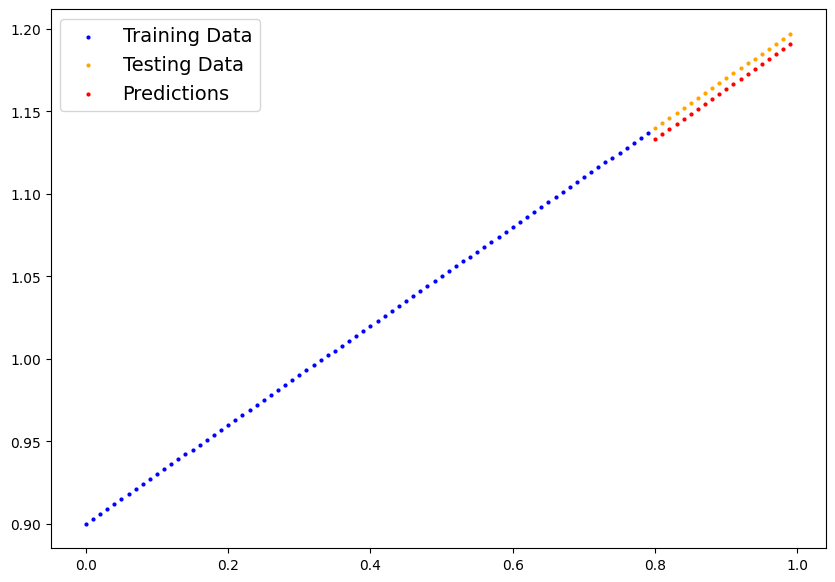

In [ ]:
plot_predictions(predictions=y_preds.cpu())

### saving the model practice

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)



saving model to: models/01_pytorch_workflow_model_2.pth


In [ ]:
loaded_model_2 = LinearRegressionModelV3()

loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_2.to(device)

LinearRegressionModelV3(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)